In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [2]:
df=pd.read_csv("../data/cancer.csv")
# df.head()

In [3]:
df = df.drop(['Unnamed: 32'],axis=1)

In [4]:
df['diagnosis'] = df['diagnosis'].map({'B':0,'M':1})
df['diagnosis'].value_counts()

0    357
1    212
Name: diagnosis, dtype: int64

In [5]:
X = df.drop('diagnosis', axis=1).values
y = df['diagnosis'].values

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)
n_cols = X_train.shape[1]

In [7]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Before feature selection shape of the data

In [8]:
print(f"X_train {X_train.shape}\nX_test {X_test.shape}")

X_train (455, 31)
X_test (114, 31)


## Modeling before Feature selection

In [9]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(f"Training score: {clf.score(X_train,y_train)*100:.2f}") 
print(f"Testing score: {clf.score(X_test,y_test)*100:.2f}") 
# print(accuracy_score(y_test,y_pred)) # same as score()

Training score: 97.58
Testing score: 93.86


## Feature selection with XGBoost

[02:25:49] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.


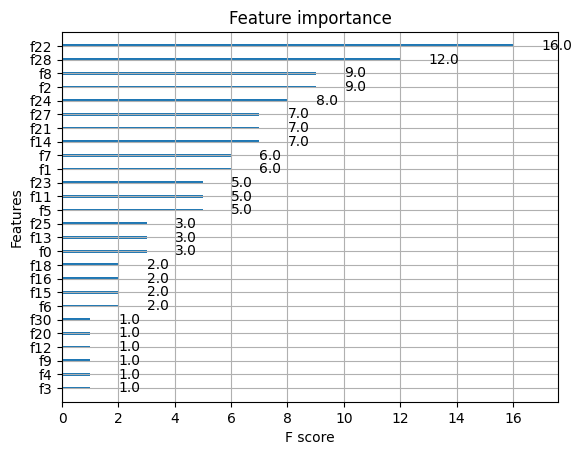

In [10]:
import xgboost as xgb
dmatrix = xgb.DMatrix(data=X, label=y)
params = {"objective":"reg:linear", "max_depth":4}
xg_clf = xgb.train(params=params, dtrain=dmatrix, num_boost_round=10)
xgb.plot_importance(xg_clf)
plt.show()

In [11]:
selected_features = [22,28,8,2,24,27,21,14,7,1]
X_train_reduced = X_train[:,selected_features]
X_test_reduced = X_test[:,selected_features]
clf.fit(X_train_reduced, y_train)
y_pred = clf.predict(X_test_reduced)
print(f"Training score: {clf.score(X_train_reduced,y_train)*100:.2f}") 
print(f"Testing score: {clf.score(X_test_reduced,y_test)*100:.2f}") 

Training score: 96.70
Testing score: 93.86


## After feature selection shape of the data

In [12]:
print(f"X_train {X_train_reduced.shape}\nX_test {X_test_reduced.shape}")

X_train (455, 10)
X_test (114, 10)


## Learning curve

In [13]:
def curve(Xtrain,ytrain,title="Learning curve"):
    train_sizes, train_scores, test_scores = learning_curve(clf, Xtrain, ytrain, cv=10, scoring='accuracy')

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)

    plt.plot(train_sizes, train_mean, label='Training Score')
    plt.plot(train_sizes, test_mean, label='Cross-Validation Score')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1)
    plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1)

    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend(loc='best')

    plt.show()

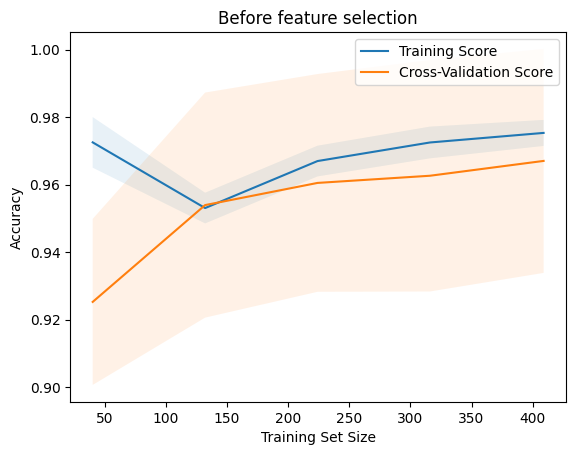

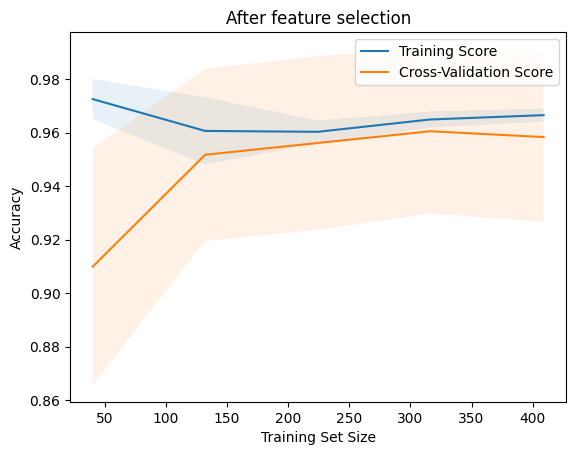

In [15]:
curve(X_train, y_train, "Before feature selection")
curve(X_train_reduced, y_train, "After feature selection")